In [25]:
import timm
import torch
from sklearn import metrics
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from test_dataset import Test_Dataset

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
config = {"batch_size": 41}

In [15]:
def expand_prediction(arr):
    arr_reshaped = arr.reshape(-1, 1)
    return np.clip(np.concatenate((1.0 - arr_reshaped, arr_reshaped), axis=1), 0.0, 1.0)

In [20]:
def validate(df, root_dir, mode):
    model = timm.create_model("tf_efficientnet_b4_ns", pretrained=False, num_classes=1)
    if mode == "random_erase":
        model.load_state_dict(torch.load("weights/random_erase_tf_efficientnet_b4_ns.h5", map_location=device))
    elif mode == "face_cutout":
        model.load_state_dict(torch.load("weights/face_cutout_tf_efficientnet_b4_ns.h5", map_location=device))
    model.to(device)

    data = Test_Dataset(df, root_dir)
    data_loader = DataLoader(
        data,
        batch_size=config["batch_size"],
        num_workers=8,
        shuffle=True,
        drop_last=True,
    )

    predictions = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            batch_images = batch["image"].to(device)
            batch_labels = batch["label"].to(device)

            out = model(batch_images)

            batch_targets = (batch_labels.view(-1, 1).cpu() >= 0.5) * 1
            batch_preds = torch.sigmoid(out).cpu()

            targets.append(batch_targets)
            predictions.append(batch_preds)

        targets = np.vstack((targets)).ravel()
        predictions = np.vstack((predictions)).ravel()

        return targets, predictions

In [21]:
def evaluate(targets, predictions):
    auc = metrics.roc_auc_score(targets, predictions)
    mAP = metrics.average_precision_score(targets, predictions)
    log_loss = metrics.log_loss(targets, expand_prediction(predictions))

    print('')
    print(f"AUC : {auc}")
    print(f"mAP : {mAP}")
    print(f"LogLoss : {log_loss}")

In [22]:
df = pd.read_csv("validation_dataset/validation_labels.csv")

print("Face Cutout --------------")
t1, p1 = validate(df, root_dir="validation_dataset/mini_val", mode="face_cutout")
evaluate(t1, p1)
# print()
# print("Random Erase -------------")
# t2, p2 = validate(df, root_dir="validation_dataset/mini_val", mode="random_erase")
# evaluate(t2, p2)

Face Cutout --------------


100%|██████████| 40/40 [06:48<00:00, 10.21s/it]


AUC : 0.9659972810254418
mAP : 0.992774114328794
LogLoss : 0.21125714678726182


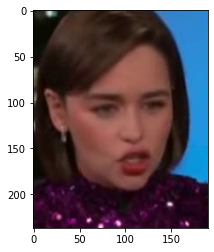

In [26]:
img = cv2.imread('validation_dataset/mini_val/00282_150_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [24]:
t1[431], p1[431]

(0, 0.02932067)

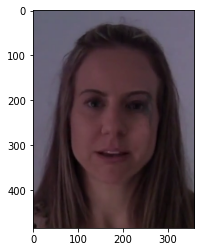

In [28]:
img = cv2.imread('validation_dataset/mini_val/ysdtdauppf_20_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [27]:
t1[433], p1[433]

(1, 0.98779404)